# Data Processing

## Setup

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Step 1 - Split matches into point segments

Starting from the full match videos and the annotations, we split them into shorter segments containing a single point.

In [ ]:
# Import libraries
import os
import json
import cv2
from tqdm import tqdm

In [ ]:
# Constants
from __init__ import data_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
videos_path = os.path.join(dataset_path, "videos")
annotations_path = os.path.join(dataset_path, "annotations")

# Read videos
videos = sorted(os.listdir(videos_path))
print("___VIDEOS___")
for video in videos: print(video)

# Determine where to save segments
segments_path = os.path.join(dataset_path, "segments_alt")
os.makedirs(segments_path, exist_ok=True)

In [ ]:
def segment_video(
    video, 
    segment_by="Point", 
    videos_path=videos_path, 
    annotations_path=annotations_path, 
    segments_path=segments_path,
    overwrite=False,
):
    # Video & annotation path
    video_name, video_ext = os.path.splitext(video)
    video_path = os.path.join(videos_path, video)
    annotation_path = os.path.join(annotations_path, video.replace(video_ext, ".json"))

    # Load annotation
    with open(annotation_path) as annotation_file:
        annotation = json.load(annotation_file)

    # Load video
    capture = cv2.VideoCapture(video_path)
    frame = 0

    # Get resolution & framerate from capture
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    # Perform segmentation
    segments = annotation["classes"][segment_by]
    for index, segment in tqdm(enumerate(segments)):
        # Determine path to save current segment
        segment_nr = f"{index}".zfill(4)
        segment_name = f"{video_name}_{segment_nr}"
        segment_path = os.path.join(segments_path, f"{segment_name}.mp4")

        # Don't overwrite if not needed
        if os.path.exists(segment_path) and not overwrite:
            continue

        # Open video writer
        writer = cv2.VideoWriter(segment_path, cv2.VideoWriter_fourcc(*"avc1"), fps, (frame_width, frame_height))

        # segment points
        start, end = int(segment["start"]), int(segment["end"])

        # Fast forward to start of segment
        frame = start
        capture.set(1, frame)
        
        # Save frames to segment
        while_safety = 0
        max_while_safety = 500
        while frame < end:
            # Read frame
            ret, img = capture.read()

            # Sometimes OpenCV reads None's during a video, in which case we want to just skip
            assert while_safety < max_while_safety, f"ERROR, cv2 read {max_while_safety} Nones"
            if ret == 0 or img is None: 
                while_safety += 1
                continue 
            while_safety = 0

            # Write frame
            writer.write(img)

            # Increase frame counter
            frame += 1
        
        # Release writer
        writer.release()
    

In [ ]:
segment_video(videos[0], overwrite=True)

In [ ]:
for video in videos:
    print(f"Segmenting video {video}")
    segment_video(video, overwrite=True)

In [ ]:
segment_files = [f for f in os.listdir(segments_path) if f.endswith('.mp4')]
n_segments = len(segment_files)
total_frames = 0
total_duration = 0
for segment in segment_files:
    segment_path = os.path.join(segments_path, segment)
    # Give the duration and number of frames of the video
    data = cv2.VideoCapture(segment_path) 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS)
    
    # calculate duration of the video 
    duration = frames / fps

    # Add to total
    total_frames += frames
    total_duration += duration

print(f"Total number of videos: {n_segments}")
print(f"Total number of frames: {total_frames}")
print(f"Total duration: {total_duration / 60 / 60:.2f} hours")
print(f"Average duration per video: {total_duration / n_segments:.2f} seconds")

## Step 2 - Court Detection

Starting from the segments extracted in the previous step, we perform tennis court detection.

- If detection fails, the frame is discarded as most likely the tennis court is not in view yet.
- For succesful detection, the frame is exported as an image along with the court point annotations.

In [ ]:
# Import libraries
import os
import time
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# Import tennis court detector
import sys
cwd = os.getcwd()
tennis_court_detector_path = os.path.abspath(os.path.join(cwd, "tennis-court-detector"))
sys.path.append(tennis_court_detector_path)
from tracknet import BallTrackerNet
from postprocess import postprocess, refine_kps
from homography import get_trans_matrix, refer_kps

In [ ]:
# Constants
from __init__ import data_path, models_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")
labels_path = os.path.join(dataset_path, "labels")
os.makedirs(labels_path, exist_ok=True)

In [ ]:
# Read segment files
segment_files = [file for file in sorted(os.listdir(segments_path)) if os.path.splitext(file)[-1] == ".mp4"]
print(f"Number of segment files: {len(segment_files)}")

We load the model provided by the developer of [TennisCourtDetector](https://github.com/yastrebksv/TennisCourtDetector).   
[Download Here](https://drive.google.com/file/d/1f-Co64ehgq4uddcQm1aFBDtbnyZhQvgG/view)

In [ ]:
# Load model
model_path = os.path.join(models_path, "court_detection", "model.pt")
assert os.path.exists(model_path), "Please download model"
model = BallTrackerNet(out_channels=15)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
#model.eval()

In [ ]:
# Process video
def quadrilateral_area(points):
    assert len(points) == 4, "This function is meant for quadrilaterals"
    indx = [0, 1, 3, 2]
    area = 0
    for i in range(len(points) - 1):
        area += points[indx[i]][0] * points[indx[i+1]][1] 
        area -= points[indx[i]][1] * points[indx[i+1]][0]
    area += points[-1][0] * points[0][1]
    area -= points[-1][1] * points[0][0]

    return abs(area / 2)

def segment_court_detection(
    segment, 
    segments_path=segments_path, 
    labels_path=labels_path, 
    use_refine_kps = True, 
    use_homography = True,
    out_video_path = None,
    verbose=False,
    overwrite=False,
):
    start_time = time.time()
    # Constants
    IMG_WIDTH = 640
    IMG_HEIGHT = 360
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT

    # Read video
    segment_name = os.path.splitext(segment)[0]
    labels_dir = os.path.join(labels_path, segment_name)
    if os.path.exists(labels_dir) and not overwrite:
        if verbose:
            print(f"Labels for {segment_name} already exist")
        return
    os.makedirs(labels_dir, exist_ok=True)
    video_path = os.path.join(segments_path, segment)
    capture = cv2.VideoCapture(video_path)
    frame = 0

    # Video information
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    # Video writer
    if out_video_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*"avc1")
        writer = cv2.VideoWriter(out_video_path, fourcc, fps, (frame_width, frame_height))    
    
    # Print setup time
    setup_time = time.time()
    if verbose:
        print(f"Setup time: {setup_time - start_time}")

    # Read frames
    while_safety = 0
    max_while_safety = 500
    while True:
        # Read image
        frame_start_time = time.time()
        ret, img = capture.read()
        if not ret:
            if verbose:
                print("Done processing")
            break

        # Sometimes OpenCV reads None's during a video, in which case we want to just skip
        assert while_safety < max_while_safety, f"ERROR: Corrupt Video"
        if img is None:
            print("WARNING: CV2 READ INVALID FRAME")
            while_safety += 1
            continue
        while_safety = 0

        # Pre-process image
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        inp = img_resized.astype(np.float32) / 255.
        inp = torch.tensor(np.rollaxis(inp, 2, 0))
        inp = inp.unsqueeze(0)
        
        # Print reading time
        frame_read_time = time.time()
        if verbose:
            print(f"Frame {frame} read time: {frame_read_time - frame_start_time}")

        # Detect court
        out = model(inp.float().to(device))[0]
        pred = F.sigmoid(out).detach().cpu().numpy()
        frame_inference_time =  time.time()
        if verbose:
            print(f"Frame {frame} inference time: {frame_inference_time - frame_read_time}")

        # Parse detected points
        points = []
        for point_index in range(14):
            heatmap = (pred[point_index] * 255).astype(np.uint8)
            x_pred, y_pred = postprocess(heatmap, low_thresh=170, max_radius=25, scale=1.)
            points.append((x_pred, y_pred))
        
        # Check if points make any sence -- skip frame if they don't
        # top_left, top_right, bottom_left, bottom_right = points[:4]
        area = quadrilateral_area(points[:4])
        if area / IMG_AREA < 0.35:
            # Assume that the field will take a minimum certain fraction of the image
            print("WARNING: SKIPPING FRAME")
            continue

        # Improve detected points with post-processing
        if use_refine_kps:
            for point_index, (x_pred, y_pred) in enumerate(points):
                if point_index in [8, 12, 9]:
                    continue
                if x_pred is None or y_pred is None:
                    continue
                x_pred, y_pred = refine_kps(img_resized, int(y_pred), int(x_pred))
                points[point_index] = (x_pred, y_pred)
        if use_homography:
            matrix_trans = get_trans_matrix(points)
            if matrix_trans is not None:
                points = cv2.perspectiveTransform(refer_kps, matrix_trans)
                points = [np.squeeze(x) for x in points]
            else:
                print("WARNING: NO MATRIX TRANSFORMATION FOUND")
        
        # Rescale points to input img size
        for point_index, (x_pred, y_pred) in enumerate(points):
            if x_pred is None or y_pred is None:
                continue
            x_scaled = int(x_pred / IMG_WIDTH * frame_width)
            y_scaled = int(y_pred / IMG_HEIGHT * frame_height)
            points[point_index] = (x_scaled, y_scaled)

        # Postprocesssing time
        postprocess_time = time.time()
        if verbose:
            print(f"Frame {frame} postprocess time: {postprocess_time - frame_inference_time}")


        # Write labels
        frame_name = f"{frame}".zfill(4)
        cv2.imwrite(os.path.join(labels_dir, f"{frame_name}.png"), img)
        np.savetxt(os.path.join(labels_dir, f"{frame_name}_court.txt"), points)

        # Visualize points
        if out_video_path is not None:
            # Draw points
            for point_index, (x_pred, y_pred) in enumerate(points):
                if x_pred is None or y_pred is None:
                    continue
                cv2.circle(img, (int(x_pred), int(y_pred)), radius=0, color=(0, 0, 255), thickness=10)
            # Write output video visualization
            writer.write(img)

        # Increase frame
        if verbose:
            print(f"Processed frame {frame}")
        frame += 1
    
    # Release video
    if out_video_path is not None:
        writer.release()
    capture.release()


In [45]:
# Try random file
segment_court_detection(
    "V006_0051.mp4", 
    use_refine_kps = True, 
    use_homography = True,
    out_video_path = "./video.mp4",
    verbose=True,
    overwrite=True,
)

Setup time: 0.08100771903991699
Frame 0 read time: 0.268280029296875
Frame 0 inference time: 2.0179245471954346
Frame 0 read time: 0.006493806838989258
Frame 0 inference time: 2.277440071105957
Frame 0 read time: 0.007521152496337891
Frame 0 inference time: 1.7856674194335938
Frame 0 read time: 0.007207632064819336
Frame 0 inference time: 1.5362589359283447
Frame 0 read time: 0.006814002990722656
Frame 0 inference time: 1.9807393550872803
Frame 0 read time: 0.006468534469604492
Frame 0 inference time: 1.624657392501831
Frame 0 read time: 0.006836414337158203
Frame 0 inference time: 1.65704345703125
Frame 0 read time: 0.005326747894287109
Frame 0 inference time: 1.8453178405761719
Frame 0 read time: 0.006852865219116211
Frame 0 inference time: 2.023277997970581
Frame 0 read time: 0.007285118103027344
Frame 0 inference time: 2.2060115337371826
Frame 0 postprocess time: 0.09050846099853516
Processed frame 0
Frame 1 read time: 0.0034847259521484375
Frame 1 inference time: 2.070711612701416

In [ ]:
# TODO process all


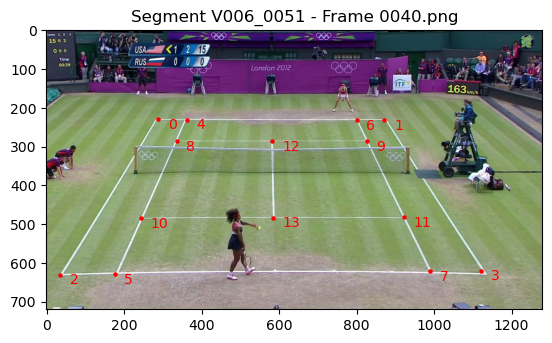

In [44]:
# Visualize results
# Pick a random video
import cv2
vids = os.listdir(labels_path)
vid = np.random.choice(vids)
vid_path = os.path.join(labels_path, vid)

# Pick a random frame
vid_frames = [file for file in os.listdir(vid_path) if os.path.splitext(file)[-1] == ".png"]
vid_frame = np.random.choice(vid_frames)

# Load frame
img = cv2.imread(os.path.join(vid_path, vid_frame))
court_points = np.loadtxt(os.path.join(vid_path, vid_frame.replace(".png", "_court.txt")))

# Visualize points
fig, ax = plt.subplots()
ax.imshow(img[:,:,::-1])
for i, (x, y) in enumerate(court_points):
    ax.text(x+25, y+25, str(i), color="r")
ax.scatter(court_points[:, 0], court_points[:, 1], c="r", s=5)
ax.set_title(f"Segment {vid} - Frame {vid_frame}")
plt.show()

## Step 2 - Detect Ball and Player Positions

In [ ]:
# Import libraries
import os
import json
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
# Constants
from __init__ import data_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")

In [ ]:
segment_files = os.listdir(segments_path)
random_file = np.random.choice(segment_files)

In [ ]:
random_file_path = os.path.join(segments_path, random_file)

In [ ]:
print(random_file_path)